In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Challenge 1 : Fire mapping - EY
## Model design and training file for our neural network
**Ordronneau Luca - Reberga Louis - Moncoutie Johan - Ettarian Julian**

This notebook describes the entire design of our model: UNET with Pretrained InceptionResNetV2 as Encoder.

We load the libraries

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.86.189.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.86.189.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Model
Structure of our model

In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="InceptionResNetV2_U-Net")
    return model

Construction of the model with the input shape as parameter

In [5]:
input_shape = (224, 224, 3)
model = build_inception_resnetv2_unet(input_shape)

Creation of metrics :

*   **iou_coef** : This is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.
*   **dice_coef** : Very similar to the IoU. They are positively correlated.
*   **dice_loss** : Dice loss gives low error as it focuses on maximising the intersection area over foreground while minimising the Union over foreground.



In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

We compile our model and adjust the hyperparameters of the model .

In [7]:
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=dice_loss, metrics=[dice_coef, iou_coef, Recall(), Precision()])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='drive/MyDrive/EY Fire/Challenge1/InceptionResNetV2_413_semi_final.h5', save_best_only=True, verbose=1)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

We load our training set

In [8]:
data = np.load('drive/MyDrive/EY Fire/Challenge1/X_Y_TRAIN_413_semi_final.npz')
X_train = data['a']
Y_train = data['b']
print(X_train.shape)

(413, 224, 224, 3)


In [9]:
# Fit the model
history = model.fit(X_train, Y_train, validation_split=0.15, batch_size=16, epochs=30, callbacks=[model_checkpoint, reduce_lr_on_plateau, early_stopping])

Epoch 1/30
22/22 [==============================] - 131s 5s/step - loss: 0.7767 - dice_coef: 0.2238 - iou_coef: 0.1380 - recall: 0.8463 - precision: 0.1744 - val_loss: 0.7790 - val_dice_coef: 0.2229 - val_iou_coef: 0.1372 - val_recall: 0.9918 - val_precision: 0.1568

Epoch 00001: val_loss improved from inf to 0.77899, saving model to drive/MyDrive/EY Fire/Challenge1/InceptionResNetV2_413_semi_final.h5
Epoch 2/30
22/22 [==============================] - 110s 5s/step - loss: 0.7181 - dice_coef: 0.2815 - iou_coef: 0.1822 - recall: 0.9503 - precision: 0.1892 - val_loss: 0.7541 - val_dice_coef: 0.2480 - val_iou_coef: 0.1568 - val_recall: 0.9943 - val_precision: 0.1669

Epoch 00002: val_loss improved from 0.77899 to 0.75406, saving model to drive/MyDrive/EY Fire/Challenge1/InceptionResNetV2_413_semi_final.h5
Epoch 3/30
22/22 [==============================] - 110s 5s/step - loss: 0.6487 - dice_coef: 0.3513 - iou_coef: 0.2397 - recall: 0.9600 - precision: 0.2608 - val_loss: 0.7431 - val_dice_

### Plot the evolution of the model on different parameters
To see if the model is valid and has not overfitted the training examples for example

dict_keys(['loss', 'dice_coef', 'iou_coef', 'recall', 'precision', 'val_loss', 'val_dice_coef', 'val_iou_coef', 'val_recall', 'val_precision', 'lr'])


Text(0.5, 0.98, 'epochs')

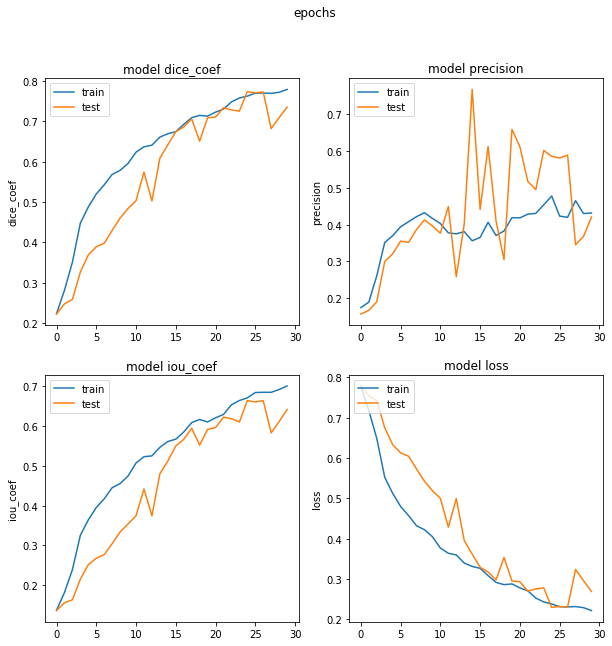

In [10]:
# list all data in history
print(history.history.keys())
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
# summarize history for dice_coef
axs[0, 0].plot(history.history['dice_coef'])
axs[0, 0].plot(history.history['val_dice_coef'])
axs[0, 0].set_title('model dice_coef')
axs[0, 0].set(ylabel='dice_coef')
#axs[0, 0].xlabel('epoch')
axs[0, 0].legend(['train', 'test'], loc='upper left')
# summarize history for precision
axs[0, 1].plot(history.history['precision'])
axs[0, 1].plot(history.history['val_precision'])
axs[0, 1].set_title('model precision')
axs[0, 1].set(ylabel='precision')
#axs[0, 1].xlabel('epoch')
axs[0, 1].legend(['train', 'test'], loc='upper left')
# summarize history for val_iou_coef
axs[1, 0].plot(history.history['iou_coef'])
axs[1, 0].plot(history.history['val_iou_coef'])
axs[1, 0].set_title('model iou_coef')
axs[1, 0].set(ylabel='iou_coef')
#axs[1, 0].xlabel('epoch')
axs[1, 0].legend(['train', 'test'], loc='upper left')
# summarize history for loss
axs[1, 1].plot(history.history['loss'])
axs[1, 1].plot(history.history['val_loss'])
axs[1, 1].set_title('model loss')
axs[1, 1].set(ylabel='loss')
#axs[1, 1].xlabel('epoch')
axs[1, 1].legend(['train', 'test'], loc='upper left')
fig.suptitle('epochs')

### Prediction on the train set
We look at the preditions on the training set

13/13 [==============================] - 24s 2s/step


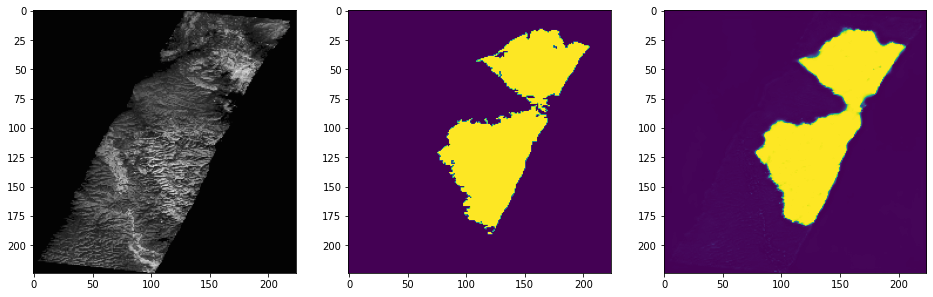

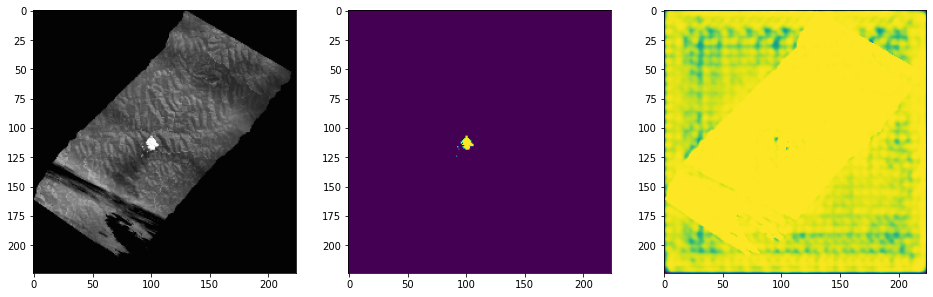

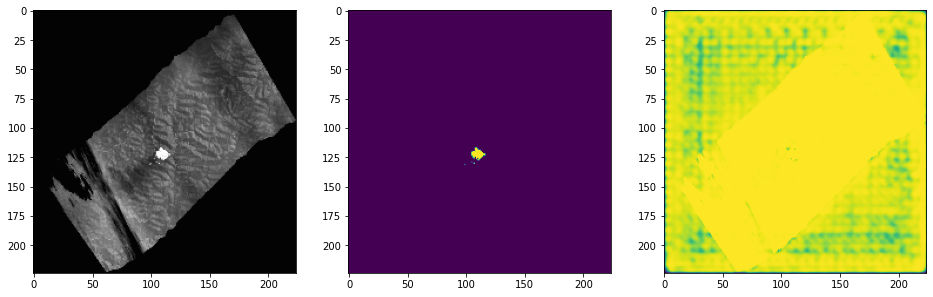

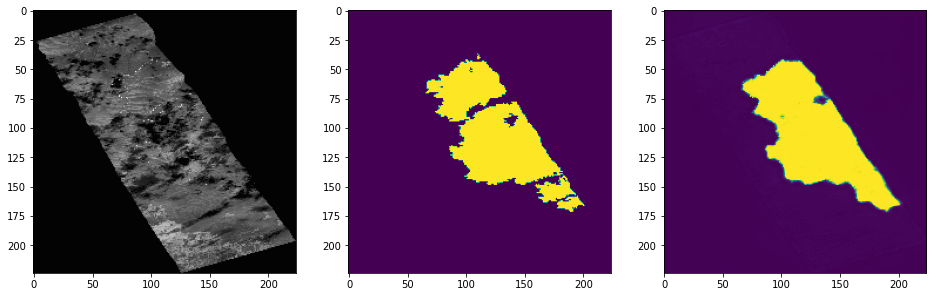

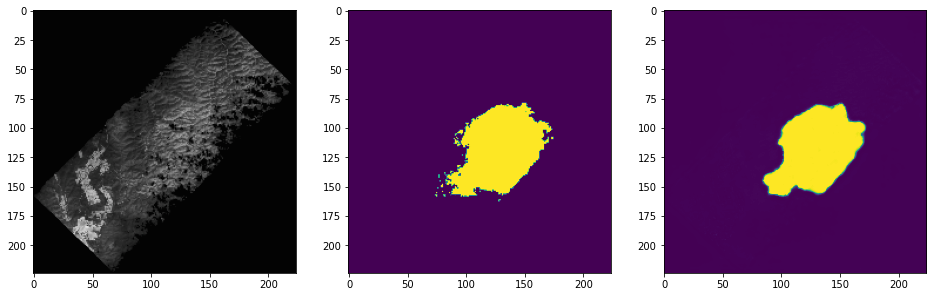

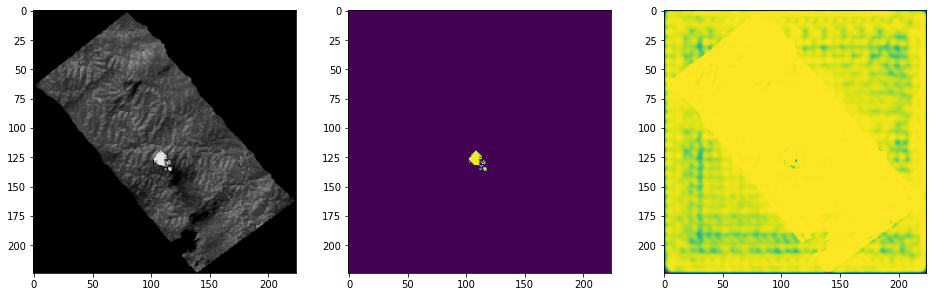

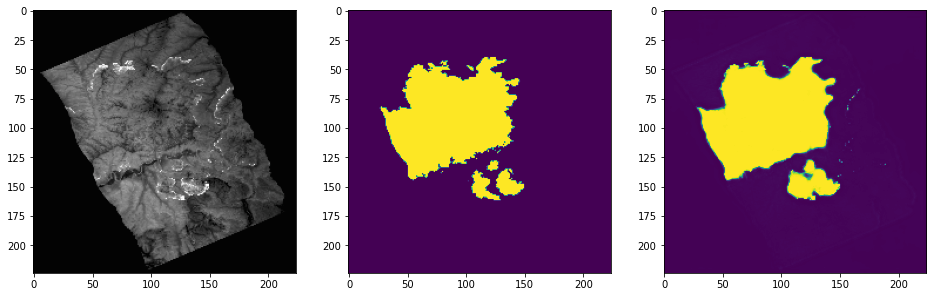

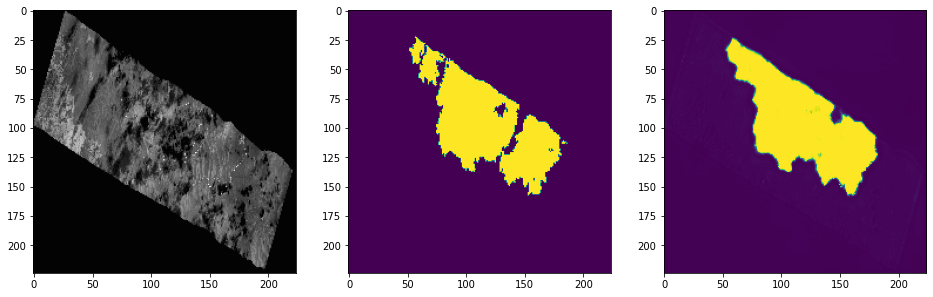

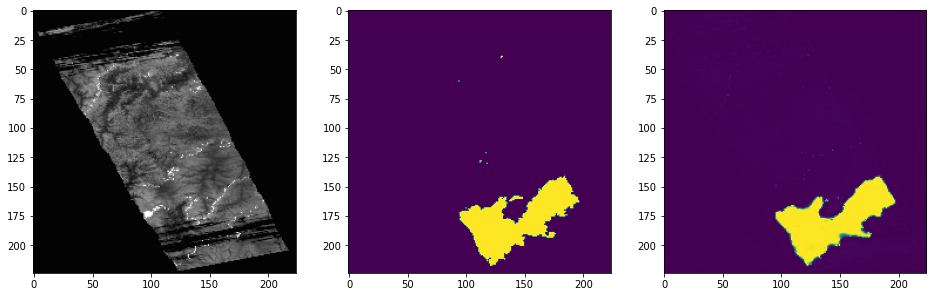

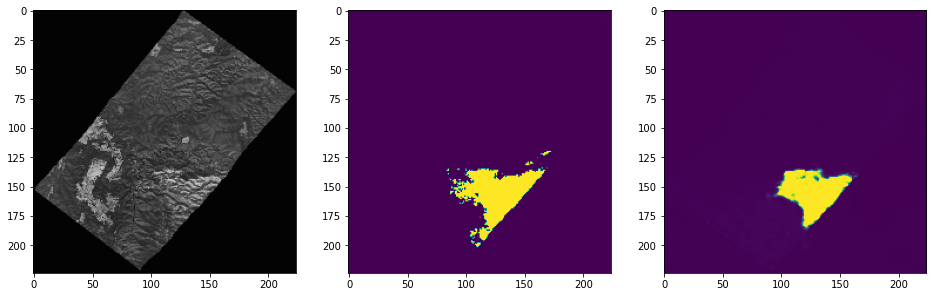

In [11]:
preds = model.predict(X_train, verbose=1)
preds = np.squeeze(preds)
liste = random.sample(range(X_train.shape[0]), 10)

for i in liste:
    pred = preds[i]  
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 3, 1)
    plt.imshow(X_train[i])
    f.add_subplot(1, 3, 2)
    plt.imshow(np.squeeze(Y_train[i]))
    f.add_subplot(1, 3, 3)
    plt.imshow(pred)
    plt.show(block=True)

### Prediction on the test set
We load the test set

In [12]:
X_test = np.load('drive/MyDrive/EY Fire/Challenge1/X_TEST_413_semi_final.npy')

We display the predictions on the test set

1/1 [==============================] - 0s 464ms/step


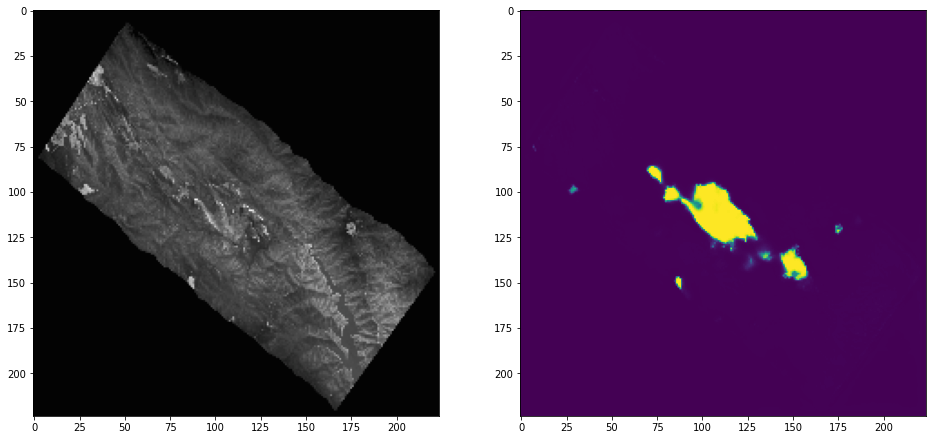

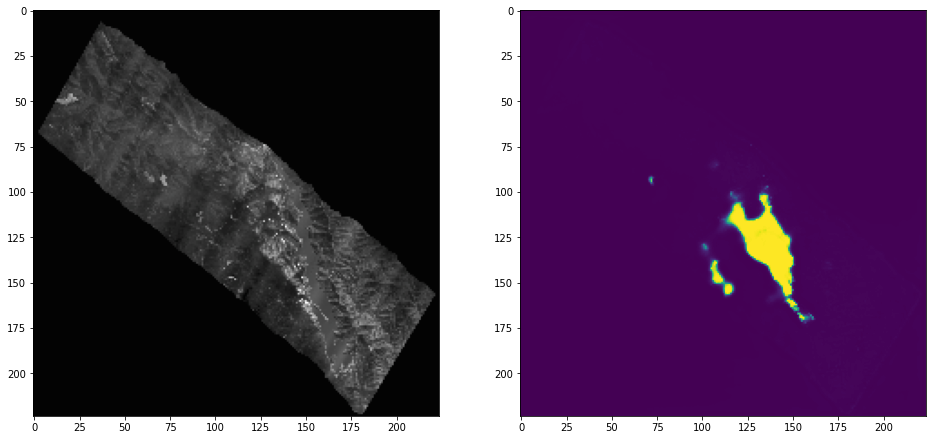

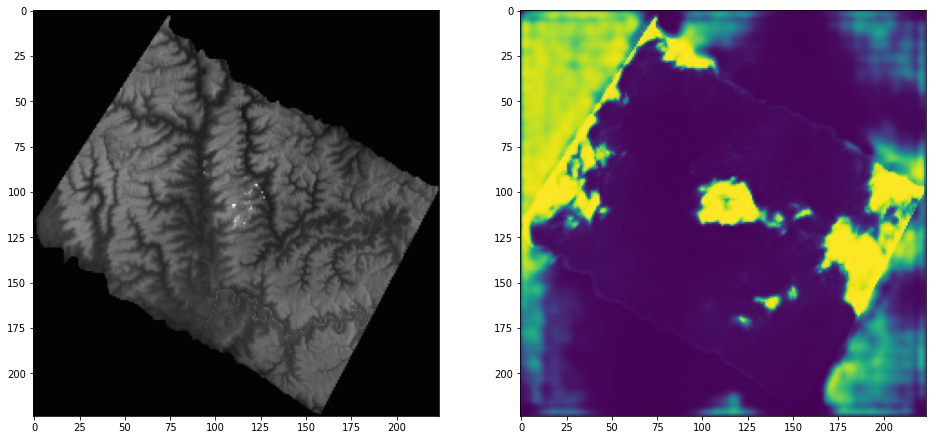

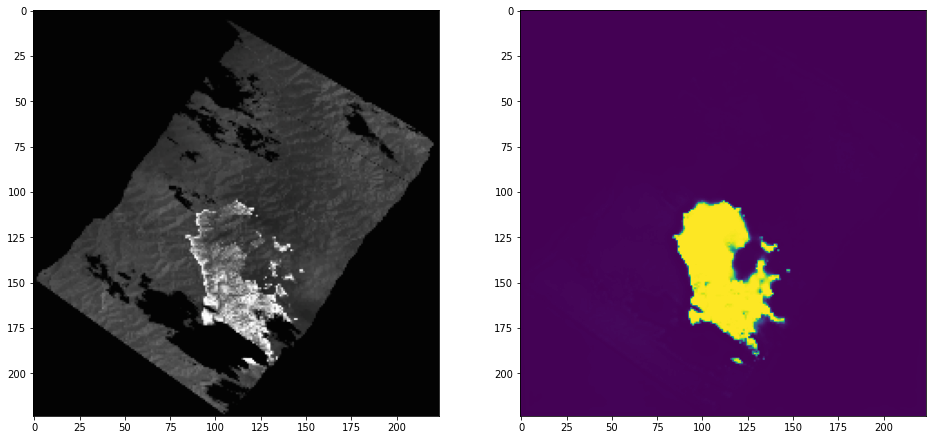

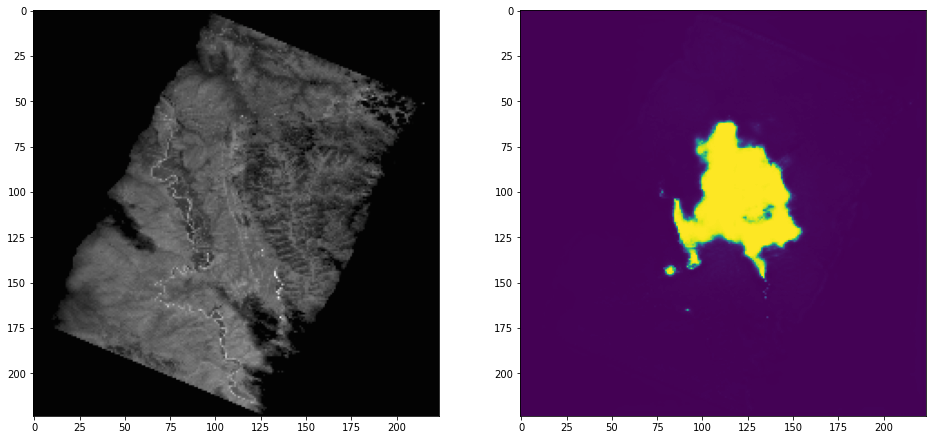

In [13]:

preds = model.predict(X_test, verbose=1)
preds = np.squeeze(preds)

for i in range(len(preds)):
    pred = preds[i]
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 2, 1)
    plt.imshow(X_test[i])
    f.add_subplot(1, 2, 2)
    plt.imshow(pred)
    plt.show(block=True)